<h1 id="This-Dataset-has-Video-stats-for-the-MrBeast-Youtube-Channel">This Dataset has Video stats for the Guitar Channel on Youtube </h1>

In [1]:
pip install isodate

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/41.7 kB ? eta -:--:--
     ---------------------------------------- 41.7/41.7 kB 1.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/7.6 MB ? eta -:--:--
                                              0.0/7.6 MB 1.9 MB/s eta 0:00:04
                                              0.1/7.6 MB 1.1 MB/s eta 0:00:07
     -                                        0.3/7.6 MB 1.8 MB/s eta 0:00:05
     -                                        0.4/7.6 MB 2.2 MB/s eta 0:00:04
     --                                       0.4/7.6 MB 1.7 MB/s eta 0:00:05
     --                                       0.5/7.6 MB 1.8 MB/s eta 0:00:04
     ---                                      0.6/7.6 MB 1.9 MB/s eta 0:00:04
     ---                                      0.7/7.6 MB 1.8 MB/s eta 0:00:04
     ---                                      0.8/7.6 MB 1.8 MB/s eta 0:00:04
     ----                                     0.8/7.6 MB 1.7 MB/s eta 0:00:05
     ----                                     0.9/7.6 MB 1.8 MB/s eta 0


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
pip install googleapiclient

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
ERROR: Could not find a version that satisfies the requirement googleapiclient (from versions: none)
ERROR: No matching distribution found for googleapiclient


In [10]:
pip install --upgrade google-api-python-client


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for google-api-python-client from https://files.pythonhosted.org/packages/13/c5/fb079e4846b0ba36d65f343cea33b36cd558986d3caa8e58a4f8d3397147/google_api_python_client-2.103.0-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/96.9 kB ? eta -:--:--
     ---------------------------------------- 96.9/96.9 kB 2.8 MB/s eta 0:00:00
  Obtaining dependency information for google-auth<3.0.0.dev0,>=1.19.0 from https://files.pythonhosted.org/packages/39/7c/2e4fa55a99f83ef9ef229ac5d59c44ceb90e2d0145711590c0fa39669f32/google_auth-2.23.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for google-auth-httplib2>=0.1.0 from https://files.pythonhosted.org/packages/d3/3d/e4991229886c0d522d9552151a43ff7adcc61e026e60ce8bd508387f84cf/google_auth_httplib2-0.1.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for google-api-core!=2.0.*,!

DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [11]:
import pandas as pd
import numpy as np
from dateutil import parser
import isodate

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

# Google API
from googleapiclient.discovery import build

In [12]:
api_key = '<your-api-key>'

In [13]:
channel_ids = ['UCX6OQ3DkcsbYNE6H8uQQuVA',
               # more channels here
              ]

In [14]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [15]:
def get_channel_stats(youtube, channel_ids):

    """
    Get channel stats

    Params:
    ------
    youtube: build object of Youtube API
    channel_ids: list of channel IDs

    Returns:
    ------
    dataframe with all channel stats for each channel ID

    """

    all_data = []

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }

        all_data.append(data)

    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):

    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')

    return video_ids


def get_video_details(youtube, video_ids):

    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)

### Get channel statistics

In [16]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [19]:
# Get video details
playlist_id = "UU-lHJZR3Gqxm24_Vd_AJ5Yw"

In [20]:
# Get video IDs
video_ids = get_video_ids(youtube, playlist_id)

In [21]:
len(video_ids)

4555

In [22]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,L0zminwWyxI,PewDiePie,I Learned 7 things in 7 days (to impress my son),#AD - 🌏 Get exclusive NordVPN deal here ➵ http...,"[pewdiepie, pewds, pewdie]",2023-10-12T17:00:26Z,1201327,100162,None,3694,PT25M22S,hd,false
1,CZy5pwKdMuo,PewDiePie,This is the best,🧎#Subscribe🧎\n\nStock Up On ➡️🥤Gfuel (affiliat...,"[pewdiepie, pewds, pewdie]",2023-10-04T17:15:00Z,3043467,245554,None,8480,PT13M56S,hd,false
2,ZFAuSU_XaZI,PewDiePie,The worst Hoarder on the Planet.,#AD - Get exclusive NordVPN deal here ➵ https:...,"[pewdiepie, pewds, pewdie]",2023-09-30T17:15:02Z,1493018,81057,None,2687,PT14M40S,hd,false
3,sK37SolFV8I,PewDiePie,i am now supreme leader,Get exclusive NordVPN deal here ➵ https://Nord...,"[pewdiepie, pewds, pewdie]",2023-09-22T16:48:14Z,1635355,120082,None,4647,PT17M26S,hd,false
4,_sPXXL9YXok,PewDiePie,dad life,Shop my OFFICIAL merch collection: https://bit...,"[pewdiepie, pewds, pewdie]",2023-09-15T15:54:58Z,3780032,250889,None,8707,PT27M56S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4550,hC7c1fhW1YM,PewDiePie,Dual Minecraft Lets Play! Episode [003] - Expl...,Thanks for SUBSCRIBING!\r\nSub 2 Xebaz: http:/...,"[minecraft, mindcraft, mind, dual, commentary,...",2010-12-19T19:03:50Z,828732,11671,None,1655,PT9M39S,hd,false
4551,XONXcdJ0278,PewDiePie,Dual Minecraft Lets Play! Episode [002] - New ...,Thanks for SUBSCRIBING!\r\n\r\nPewDiePie fails...,"[Military, Penis, exploded, in, Xebaz, face, m...",2010-12-19T00:24:52Z,1949001,33367,None,4661,PT8M42S,hd,false
4552,lUtoLyyeOwQ,PewDiePie,Call of Duty: Black Ops: Wager Match: Gun Game,100 SUBS THANK YOU! :D\nHave these running in ...,"[yt:quality=high, Call, of, Duty, Black, Ops, ...",2010-12-16T22:48:09Z,4220861,222321,None,46901,PT3M13S,hd,false
4553,0U6ZgImZ5vo,PewDiePie,Blacklight Tango Down: Team Deathmatch 38-4 (P...,Thank YOU for subscribing and participating! :...,"[yt:quality=high, blacklight, tango, down, com...",2010-12-10T20:03:23Z,1915123,43477,None,5251,PT5M37S,hd,false


In [23]:
def get_comments_in_videos(youtube, video_ids):

    all_comments = []

    for video_id in video_ids:
        try:
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()

            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)

        except:
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)

    return pd.DataFrame(all_comments)

### Get video statistics

In [24]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount          True
likeCount          True
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [25]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [26]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [27]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [28]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [29]:
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,0 days 00:25:22,PT25M22S
1,0 days 00:13:56,PT13M56S
2,0 days 00:14:40,PT14M40S
3,0 days 00:17:26,PT17M26S
4,0 days 00:27:56,PT27M56S
...,...,...
4550,0 days 00:09:39,PT9M39S
4551,0 days 00:08:42,PT8M42S
4552,0 days 00:03:13,PT3M13S
4553,0 days 00:05:37,PT5M37S


In [30]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [31]:
# Sample DataFrame with 'publishedDayName' column
import pandas as pd

# Create a dictionary to map full day names to abbreviated forms
day_name_mapping = {
    'Sunday': 'Sun',
    'Monday': 'Mon',
    'Tuesday': 'Tue',
    'Wednesday': 'Wed',
    'Thursday': 'Thu',
    'Friday': 'Fri',
    'Saturday': 'Sat'
}

# Use the map function to replace values in the DataFrame
video_df['publishDayName'] = video_df['publishDayName'].map(day_name_mapping)

# Print the modified DataFrame
print(video_df)

         video_id channelTitle  \
0     L0zminwWyxI    PewDiePie   
1     CZy5pwKdMuo    PewDiePie   
2     ZFAuSU_XaZI    PewDiePie   
3     sK37SolFV8I    PewDiePie   
4     _sPXXL9YXok    PewDiePie   
...           ...          ...   
4550  hC7c1fhW1YM    PewDiePie   
4551  XONXcdJ0278    PewDiePie   
4552  lUtoLyyeOwQ    PewDiePie   
4553  0U6ZgImZ5vo    PewDiePie   
4554  9jeJbdVl2jI    PewDiePie   

                                                  title  \
0      I Learned 7 things in 7 days (to impress my son)   
1                                      This is the best   
2                      The worst Hoarder on the Planet.   
3                               i am now supreme leader   
4                                              dad life   
...                                                 ...   
4550  Dual Minecraft Lets Play! Episode [003] - Expl...   
4551  Dual Minecraft Lets Play! Episode [002] - New ...   
4552     Call of Duty: Black Ops: Wager Match: Gun Game   
4

In [32]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishDayName,durationSecs,tagCount
0,L0zminwWyxI,PewDiePie,I Learned 7 things in 7 days (to impress my son),#AD - 🌏 Get exclusive NordVPN deal here ➵ http...,"[pewdiepie, pewds, pewdie]",2023-10-12 17:00:26+00:00,1201327.0,100162.0,NaN,3694.0,PT25M22S,hd,false,Thu,0 days 00:25:22,3
1,CZy5pwKdMuo,PewDiePie,This is the best,🧎#Subscribe🧎\n\nStock Up On ➡️🥤Gfuel (affiliat...,"[pewdiepie, pewds, pewdie]",2023-10-04 17:15:00+00:00,3043467.0,245554.0,NaN,8480.0,PT13M56S,hd,false,Wed,0 days 00:13:56,3
2,ZFAuSU_XaZI,PewDiePie,The worst Hoarder on the Planet.,#AD - Get exclusive NordVPN deal here ➵ https:...,"[pewdiepie, pewds, pewdie]",2023-09-30 17:15:02+00:00,1493018.0,81057.0,NaN,2687.0,PT14M40S,hd,false,Sat,0 days 00:14:40,3
3,sK37SolFV8I,PewDiePie,i am now supreme leader,Get exclusive NordVPN deal here ➵ https://Nord...,"[pewdiepie, pewds, pewdie]",2023-09-22 16:48:14+00:00,1635355.0,120082.0,NaN,4647.0,PT17M26S,hd,false,Fri,0 days 00:17:26,3
4,_sPXXL9YXok,PewDiePie,dad life,Shop my OFFICIAL merch collection: https://bit...,"[pewdiepie, pewds, pewdie]",2023-09-15 15:54:58+00:00,3780032.0,250889.0,NaN,8707.0,PT27M56S,hd,false,Fri,0 days 00:27:56,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4550,hC7c1fhW1YM,PewDiePie,Dual Minecraft Lets Play! Episode [003] - Expl...,Thanks for SUBSCRIBING!\r\nSub 2 Xebaz: http:/...,"[minecraft, mindcraft, mind, dual, commentary,...",2010-12-19 19:03:50+00:00,828732.0,11671.0,NaN,1655.0,PT9M39S,hd,false,Sun,0 days 00:09:39,31
4551,XONXcdJ0278,PewDiePie,Dual Minecraft Lets Play! Episode [002] - New ...,Thanks for SUBSCRIBING!\r\n\r\nPewDiePie fails...,"[Military, Penis, exploded, in, Xebaz, face, m...",2010-12-19 00:24:52+00:00,1949001.0,33367.0,NaN,4661.0,PT8M42S,hd,false,Sun,0 days 00:08:42,35
4552,lUtoLyyeOwQ,PewDiePie,Call of Duty: Black Ops: Wager Match: Gun Game,100 SUBS THANK YOU! :D\nHave these running in ...,"[yt:quality=high, Call, of, Duty, Black, Ops, ...",2010-12-16 22:48:09+00:00,4220861.0,222321.0,NaN,46901.0,PT3M13S,hd,false,Thu,0 days 00:03:13,52
4553,0U6ZgImZ5vo,PewDiePie,Blacklight Tango Down: Team Deathmatch 38-4 (P...,Thank YOU for subscribing and participating! :...,"[yt:quality=high, blacklight, tango, down, com...",2010-12-10 20:03:23+00:00,1915123.0,43477.0,NaN,5251.0,PT5M37S,hd,false,Fri,0 days 00:05:37,34


C:\Users\jibbi\AppData\Local\Temp\ipykernel_9840\2341505175.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_yticklabels(), rotation=50)


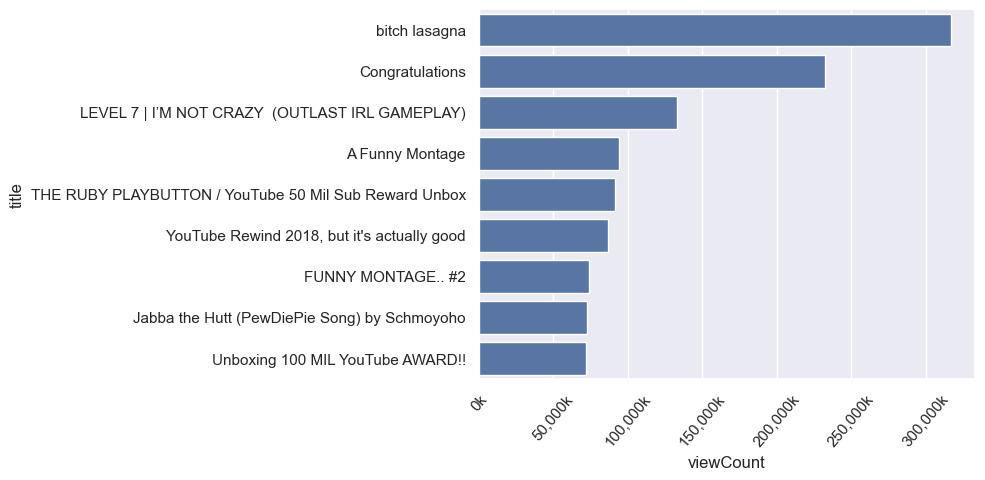

In [33]:
ax = sns.barplot(x='viewCount', y='title', data=video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_yticklabels(), rotation=50)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k'))

<Axes: xlabel='likeCount', ylabel='viewCount'>

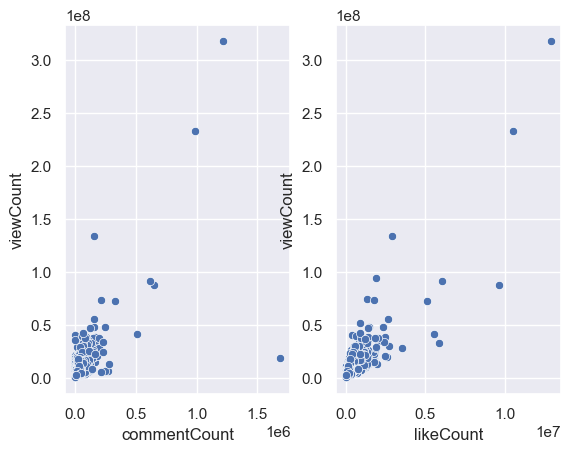

In [36]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

<Axes: xlabel='durationSecs', ylabel='Count'>

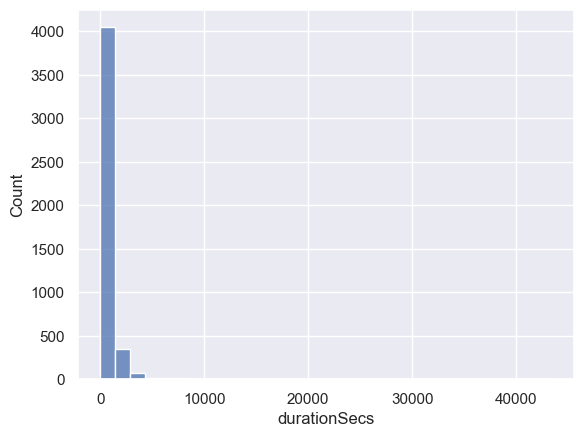

In [38]:
video_df['durationSecs'] = video_df['durationSecs'].dt.total_seconds()
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

<Axes: xlabel='durationSecs', ylabel='likeCount'>

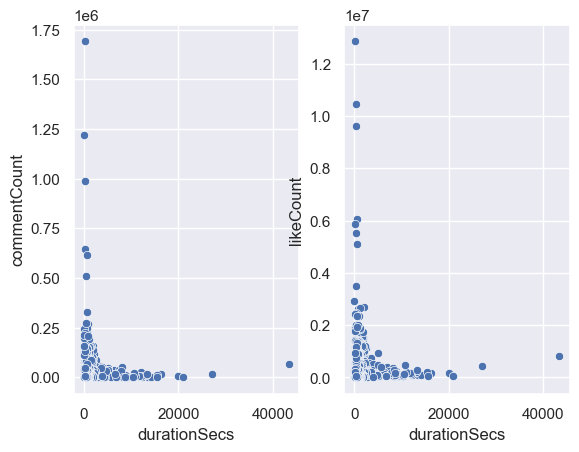

In [39]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

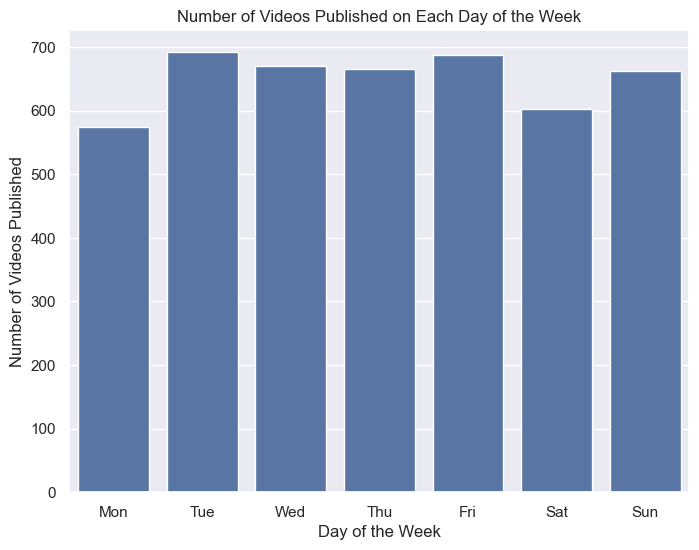

In [48]:
# Extract the day of the week from the 'publishedAt' column
video_df['publishDayName'] = video_df['publishedAt'].dt.strftime('%a')

# Count the number of videos published on each day of the week
day_count = video_df['publishDayName'].value_counts()

# Reorder the days of the week in the correct order
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_count = day_count.reindex(weekdays)

# Plot the bar graph
plt.figure(figsize=(8, 6))
sns.barplot(x=day_count.index, y=day_count.values, order=weekdays)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Videos Published')
plt.title('Number of Videos Published on Each Day of the Week')
plt.show()